<a href="https://colab.research.google.com/github/nekrut/msmb_python/blob/master/chapter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Make sure we have latest seaborn
!pip install seaborn --upgrade

    100% |████████████████████████████████| 215kB 24.8MB/s 
  Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1


In [3]:
# Make sure we have latest numpy
!pip install numpy --upgrade

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.16.2)


In [4]:
!pip install pandas --upgrade

    100% |████████████████████████████████| 10.1MB 2.9MB/s 
  Found existing installation: pandas 0.23.4
    Uninstalling pandas-0.23.4:
      Successfully uninstalled pandas-0.23.4


In [0]:
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [0]:
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# 2. Statistical Modeling
---------
In the previous chapter, the knowledge of both the generative model and the values of the parameters provided us with probabilities we could use for decision making – for instance, whether we had really found an epitope. In many real situations, neither the generative model nor the parameters are known, and we will need to estimate them using the data we have collected. Statistical modeling works from the data upwards to a model that might plausibly explain the data (Even if we have found a model that perfectly explains all our current data, it could always be that reality is more complex. A new set of data lets us conclude that another model is needed, and may include the current model as a special case or approximation). This upward-reasoning step is called statistical inference. This chapter will show us some of the distributions and estimation mechanisms that serve as building blocks for inference. Although the examples in this chapter are all parametric (i.e., the statistical models only have a small number of unknown parameters), the principles we discuss will generalize.

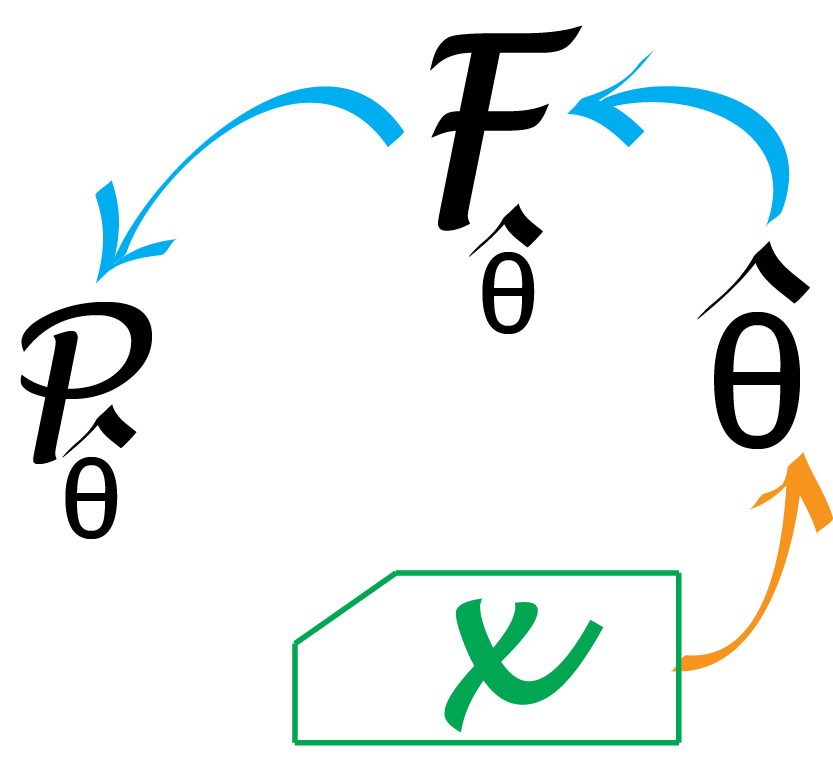

In [3]:
display(Image('http://web.stanford.edu/class/bios221/book/images/StatDiagram.png',width=300, height=300))


In a statistical setting, we start with the data $X$ and use them to estimate the parameters. These estimates are denoted by Greek letters with what we call hats on them, as in $\hat{\theta}$.

## 2.1. Goals of this chapter
--------
In this chapter we will:

 - See that there is a difference between two subjects that are often confused: “Probability” and “Statistics”.
 - Fit data to probability distributions using histograms and other visualization tricks.
 - Have a first encounter with an estimating procedure known as maximum likelihood through a simulation experiement.
 - Make inferences from data for which we have prior information. For this we will use the Bayesian paradigm which will involve new distributions with specially tailored properties. We will use simulations and see how Bayesian estimation differs from simple application of maximum likelihood.
 - Use statistical models and estimation to evaluate dependencies in binomial and multinomial distributions.
 - Analyse some historically interesting genomic data assembled into tables.
 - Make Markov chain models for dependent data.
 - Do a few concrete applications counting motifs in whole genomes and manipulate special Bioconductor classes dedicated to genomic data.
 
Parameters are the key. $\lambda$, $\mu$, $\theta$ are examples of parameters. he single parameter $\lambda$ defines a Poisson distribution. The letter $\mu$ is often used for the mean of the normal. More generally, we use the Greek letter $\theta$ to designate a generic tuple of parameters necessary to specify a probability model. For instance, in the case of the binomial distribution, $\theta = (n,p)$ comprises two numbers, a positive integer and a real number between 0 and 1.

We saw in Chapter 1 that the knowledge of all the parameter values in the epitope example enabled us to use our probability model and test a null hypothesis based on the data we had at hand. We will see different approaches to statistical modeling through some real examples and computer simulations, but let’s start by making a distinction between two situations depending on how much information is available.

## 2.2. The difference between statistical and probabilistic models
---------
A probabilistic analysis is possible when we know a good generative model for the randomness in the data, and we are provided with the parameters’ actual values.

In the epitope example, knowing that false positives occured as Bernoulli(0.01) per position, the number of patients assayed and the length of the protein ensured that there were no unknown parameters.

In such a case, we can use mathematical deduction to compute the probability of an event as schematized in Figure 2.1 below. In the epitope examples, we used the Poisson probability as our null model with the given parameter $\lambda = 0.5$. We were able to conclude through mathematical deduction that the chances of seeing a maximum value of $7$ or larger was around $10^{-4}$ and thus that in fact the observed data were highly unlikely under that model (or “null hypothesis”).

Now suppose that we know the number of patients and the length of the proteins (these are given by the experimental design) but not the distribution itself and the false positive rate. Once we observe data, we need to go up from the data to estimate both a probability model $F$ (Poisson, normal, binomial) and eventually the missing parameter(s) for that model. This is the type of statistical inference we will explain in this chapter.

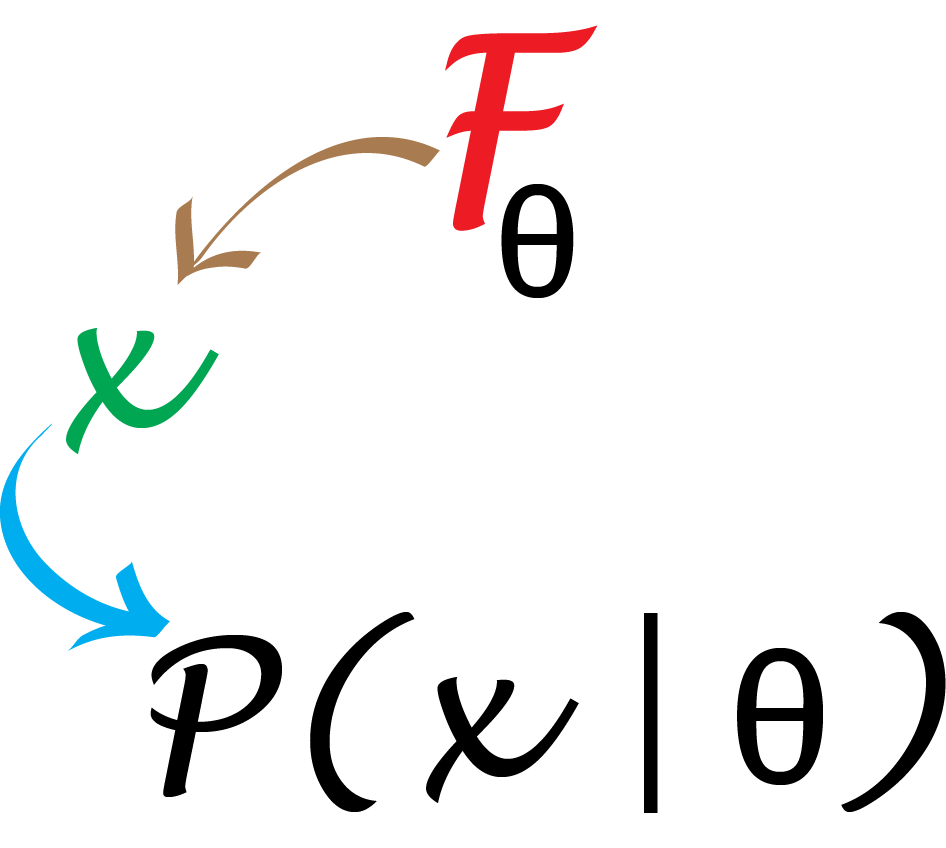

In [4]:
display(Image('http://web.stanford.edu/class/bios221/book/images/ProbaDiagram.png',width=300, height=300))

>**Figure 2.1**. The probabilistic model we obtained in Chapter 1. The data are represented as $x$ in green. We can use the observed data to compute the probability of observing $x$ when we know the true value of $\theta$.



## 2.3. A simple example of statistical modeling
-------
Start with the data

There are two parts to the modeling procedure. First we need a reasonable probability distribution to model the data generation process. As we saw in Chapter 1, discrete count data may be modeled by simple probability distributions such as binomial, multinomial or Poisson distributions. The normal distribution, or bell shaped curve, is often a good model for continuous measurements. Distributions can also be more complicated mixtures of these elementary ones (more on this in Chapter 4).

Let’s revisit the epitope example from the previous chapter, starting without the tricky outlier.

In [5]:
!pip install pyreadr

    100% |████████████████████████████████| 266kB 7.3MB/s 


In [6]:
!wget https://github.com/nekrut/msmb_python/raw/master/data/e100.RData

--2019-04-16 13:18:55--  https://github.com/nekrut/msmb_python/raw/master/data/e100.RData
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nekrut/msmb_python/master/data/e100.RData [following]
--2019-04-16 13:18:55--  https://raw.githubusercontent.com/nekrut/msmb_python/master/data/e100.RData
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129 [application/octet-stream]
Saving to: ‘e100.RData’

e100.RData          100%[===================>]     129  --.-KB/s    in 0s      

2019-04-16 13:18:55 (5.87 MB/s) - ‘e100.RData’ saved [129/129]



In [0]:
import pyreadr
df = pyreadr.read_r('e100.RData')['e100']

In [0]:
e99 = df[df['e100']<7]

Goodness-of-fit : visual evaluation

Our first step is to find a fit from candidate distributions; this requires consulting graphical and quantitative goodness-of-fit plots. For discrete data, we can plot a barplot of frequencies (for continuous data, we would look at the histogram) as in Figure 2.2:

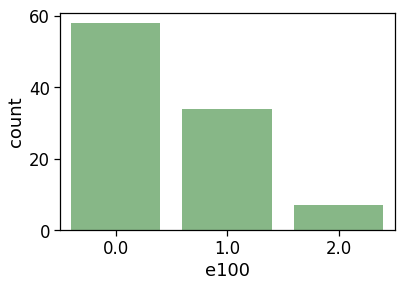

In [9]:
sns.countplot(e99['e100'], color='g', alpha=0.5)

>**Figure 2.2.** The observed distribution of the epitope data without the outlier.

However, it is hard to decide which theoretical distribution fits the data best without using a comparison. One visual goodness-of-fit diagram is known as the rootogram (Cleveland 1988); it hangs the bars with the observed counts from the theoretical red points. If the counts correspond exactly to their theoretical values, the bottom of the boxes will align exactly with the horizontal axis.

In [0]:
mlest = e99['e100'].mean()

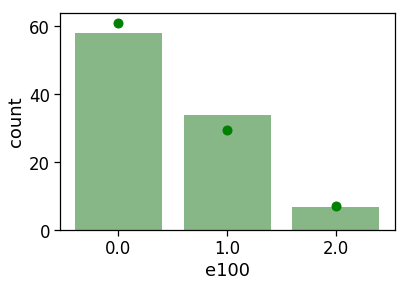

In [11]:
from scipy.stats import poisson
k = np.arange(e99['e100'].max()+1)
sns.countplot(e99['e100'], order=k, color='g', alpha=0.5)
plt.plot(k, poisson.pmf(k, mlest)*len(e99), 'go', markersize=9)

We see that the rootogram for e99 seems to fit the Poisson model reasonably well. But remember, to make this happen we removed the outlier. The Poisson is completely determined by one parameter, often called the Poisson mean $\lambda$. In most cases where we can guess the data follows a Poisson distribution, we will need to estimate the Poisson parameter from the data.

The parameter is called the Poisson mean because it is the mean of the theoretical distribution and, as it turns out, is estimated by the sample mean. This overloading of the word is confusing to everyone.

The most common way of estimating $\lambda$ is to choose the value $\hat{\lambda}$ that makes the observed data the most likely. This is called the maximum likelihood estimator (Rice 2006 Chapter 8, Section 5), often abbreviated MLE. We will illustrate this rather paradoxical idea in the next section.

Although we above took out the extreme observation before taking a guess at the probability distribution, we are going to return to the data with it for the rest of our analysis. In practice we would not know whether there is an outlier, and which data point(s) it is / they are. The effect of leaving it in is to make our estimate of the mean higher. In turns this would make it more likely that we’d observe a value of 7 under the null model, resulting in a larger p-value. So, if the resulting p-value is small even with the outlier included, we are assured that our analysis is up to something real. We call such a tactic being conservative: we err on the side of caution, of not detecting something.

#### Estimating the parameter of the Poisson distribution

What value for the Poisson mean makes the data the most probable? In a first step, we tally the outcomes:

In [12]:
df['e100'].value_counts()

0.0    58
1.0    34
2.0     7
7.0     1
Name: e100, dtype: int64

Then we are going to try out different values for the Poisson mean and see which one gives the best fit to our data. If the mean $\lambda$ of the Poisson distribution were 3, the counts would look something like this:

In [0]:
x,y = np.unique(poisson.rvs(mu=3,size=100),return_counts=True)

In [14]:
x

array([0, 1, 2, 3, 4, 5, 6, 8, 9])

In [15]:
y

array([ 7, 10, 32, 17, 15, 12,  2,  3,  2])

which has many more 2’s and 3’s than we see in our data. So we see that $\lambda=3$ is unlikely to have produced our data, as the counts do not match up so well.

&#9757;  Repeat this simulation with different values of $\lambda$ Can you find one that gives counts close to the oberved ones just by trial and error?

So we could try out many possible values and proceed by brute force. However, we’ll do something more elegant and use a little mathematics to see which value maximizes the probability of observing our data. Let’s calculate the probability of seeing the data if the value of the Poisson parameter is $m$. Since we suppose the data derive from independent draws, this probability is simply the product of individual probabilities:

$P(58 \times 0, 34 \times 1, 7 \times 2, 1 \times 7 | data\ are\ Poisson(m))=P(0)^{58} \times P(1)^{34} \times P(2)^{7} \times P(7)^1\\$
for $m=3$ we can compute this:

In [16]:
from numpy import prod
prod(poisson.pmf([0,1,2,7],mu=3)**[58,34,7,1])

1.3921432708903147e-110

&#9757; Compute the probability as above for $m=0,1,2$. Does $m$ have to be integer? Try computing the probability for $m=0.4$ for example.

This probability is the likelihood function of $\lambda$, given the data, and we write it:

$L(\lambda,x=(k_1,k_2,k_3,...))=\prod_{i=1}^{100}f(k_i)\\$

where $L$ stands for likelihood and $f(k)=e^{-\lambda}/k!$, the Poisson probability we saw earlier.

Instead of working with multiplications of a hundred small numbers, it is convenient (That’s usually true both for pencil and paper and for computer calculations.)  to take the logarithm. Since the logarithm is strictly increasing, if there is a point where the logarithm achieves its maximum within an interval it will also be the maximum for the probability.

Let’s start with a computational illustration. We compute the likelihood for many different values of the Poisson parameter. To do this we need to write a small function that computes the probability of the data for different values

In [0]:
def loglikelihood(l,data):
  return np.sum(np.log(poisson.pmf(data,mu=l)))

In [0]:
lambdas=np.linspace(0.05,0.95,100)

In [19]:
lambdas

array([0.05      , 0.05909091, 0.06818182, 0.07727273, 0.08636364,
       0.09545455, 0.10454545, 0.11363636, 0.12272727, 0.13181818,
       0.14090909, 0.15      , 0.15909091, 0.16818182, 0.17727273,
       0.18636364, 0.19545455, 0.20454545, 0.21363636, 0.22272727,
       0.23181818, 0.24090909, 0.25      , 0.25909091, 0.26818182,
       0.27727273, 0.28636364, 0.29545455, 0.30454545, 0.31363636,
       0.32272727, 0.33181818, 0.34090909, 0.35      , 0.35909091,
       0.36818182, 0.37727273, 0.38636364, 0.39545455, 0.40454545,
       0.41363636, 0.42272727, 0.43181818, 0.44090909, 0.45      ,
       0.45909091, 0.46818182, 0.47727273, 0.48636364, 0.49545455,
       0.50454545, 0.51363636, 0.52272727, 0.53181818, 0.54090909,
       0.55      , 0.55909091, 0.56818182, 0.57727273, 0.58636364,
       0.59545455, 0.60454545, 0.61363636, 0.62272727, 0.63181818,
       0.64090909, 0.65      , 0.65909091, 0.66818182, 0.67727273,
       0.68636364, 0.69545455, 0.70454545, 0.71363636, 0.72272

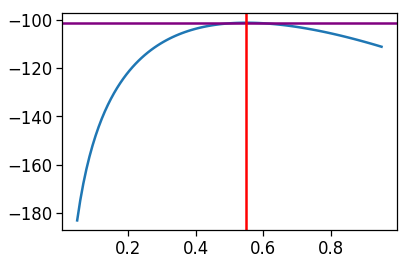

In [20]:
g = sns.lineplot(x=lambdas, y=([ loglikelihood(x,df['e100']) for x in lambdas ]))
g.axhline(loglikelihood(0.55,df['e100']),color='purple')
g.axvline(np.mean(df['e100']),color='r')

### 2.3.1. Classical statistics for classical data

Here is a formal proof of our computational finding that the mean maximizes the (log-)likelihood:

$logL(\lambda,x)=\sum_{i=1}^{100}-\lambda+k_ilog\lambda-log(k_i!)=\\
= -100\lambda+log\lambda(\sum_{i=i}^{100}k_i)+const.$

We use the catch-all “const.” for terms that do not depend on $\lambda$ (although they do depend on $x$, i.e., on the $k_i$).  To find the $\lambda$ that maximizes this, we compute the derivative in $\lambda$ and set it to zero:

$\frac{d}{d\lambda}logL=-100+\frac{1}{\lambda}\sum_{i=1}^{100}k_i=0//
\lambda=\frac{1}{100}\sum_{i=1}^{100}k_i=\bar{k}\\$

You have just seen the first steps of a *statistical approach*, starting "from the ground up" (from the data) to infer the model parameter(s): this is statistical *estimation* a parameter from data. Another important component will be choosing which family of distributions our data come from, that part is done by evaluating the *goodness of fit*. We will encounter this later.

In the classical *statistical* testing framework, we consider one single model, that we call the *null model*, for the data. The null model formulates an “uninteresting” baseline, such as that all observations come from the same random distribution regardless of which group or treatment they are from. We then test whether there is something more interesting going on by computing the probability that the data are compatible with that model. Often, this is the best we can do, since we do not know in sufficient detail what the “interesting”, non-null or alternative model should be. In other situations, we have two competing models that we can compare, as we will see later.

Another useful direction is regression. We may be interested in knowing how our count-based response variable (e.g., the result of counting sequencing reads) depends on a continuous covariate, say, temperature or nutrient concentration. You may already have encountered linear regression, where our model is that the response variable $y$ depends on the covariate $x$ via the equation $y=ax+b+e$, with parameters $a$ and $b$ (that we need to estimate), and with residuals $e$ whose probability model is a normal distribution (whose variance we usually also need to estimate). For count data the same type of regression model is possible, although the probability distribution for the residuals then needs to be non-normal. In that case we use the generalized linear models framework. We will see examples when studying RNA-Seq in Chapter 8 and another type of next generation sequencing data, 16S rRNA data, in Chapter 9.

Knowing that our probability model involves a Poisson, binomial, multinomial distribution or another parametric family will enable us to have quick answers to questions about the parameters of the model and compute quantities such as p-values and confidence intervals.

## 2.4. Binomial distributions and maximum likelihood
-------
In a binomial distribution there are two parameters: the number of trials $n$, which is typically known, and the probability $p$ of seeing a 1 in a trial. This probability is often unknown.

### 2.4.1. An example

Suppose we take a sample of $n=120$ males and test them for red-green colorblindness. We can code the data as 0 if the subject is not colorblind and 1 if he is. We summarize the data by the table:

In [0]:
cb = np.hstack((np.zeros(110),np.ones(10)))

In [22]:
cb

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [23]:
np.unique(cb,return_counts=True)

(array([0., 1.]), array([110,  10]))

&#9757; Which value of $p$ is the most likely given these data?

In this special case, your intuition may give you the estimate $\hat p=\frac{1}{12}$, which turns out to be the maximum likelihood estimate. We put a hat over the letter to remind us that this is not (necessarily) the underlying true value, but an estimate we make from the data.

As before in the case of the Poisson, if we compute the likelihood for many possible $p$, we can plot it and see where its maximum falls:

In [0]:
probs = np.arange(0,0.301,step=0.005)

In [0]:
from scipy.stats import binom
likelihood=binom.pmf(k=np.sum(cb),n=len(cb),p=probs)

[Text(0, 0.5, 'likelihood'), Text(0.5, 0, 'probaility of success')]

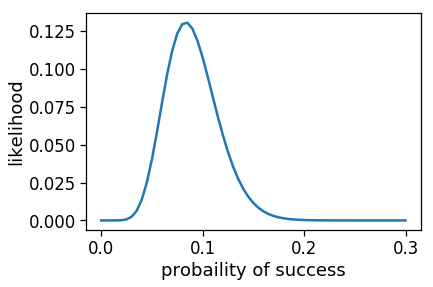

In [26]:
g=sns.lineplot(x=probs, y=likelihood)
g.set(xlabel="probaility of success",ylabel="likelihood")

>**Figure 2.5.** Plot of the likelihood as a function of the probabilities. The likelihood is a function on $[0,1]$; here we have zoomed into the range of $[0,0.3]$, as the likelihood is practically zero for larger values of $p$.

In [27]:
probs[np.argmax(likelihood)]

0.085

Note: 0.085 is not exactly the value we expected ($\frac{1}{12}$), and that is because the set of values that we tried (in probs) did not include the exact value of 
$\frac{1}{12}\simeq0.0833$, so we obtained the next best one. We could use numeric optimisation methods to overcome that.

#### Likelihood for the binomial distribution
 
One can come up with different criteria than ML, which lead to other estimators: they all carry hats. We'll see other examples in Chapter 4. The likelihood and the probability are the same mathematical function, only interpreted in different ways – in one case, it tells us how probable it is to see a particular set of values of the data, given the parameters; in the other case, we consider the data as fixed, and ask for the particular parameter value that makes the data more likely. Suppose 
$n=300$, and we observe $y=40$ successes. Then, for the binomial distribution:

$f(\theta|n,y)=f(y|n,\theta)=\binom{n}{y}\theta^y(1-\theta)^{(n-y)}.\\$

As $\binom{n}{y}$ is very large (It's around $e^{115}$ , and this can be seen from Stirling’s formula.) we use the logarithm of the likelihood to give:

$logF(\theta|y)=115+40log(\theta)+(300-40)log(1-\theta)$.

Here’s a function we use to calculate it:

In [0]:
def loglikelihood(theta, n=300,k=40):
  return(115+k*np.log(theta)+(n-k)*np.log(1-theta))

In [0]:
thetas=np.arange(0,1,step=0.001)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


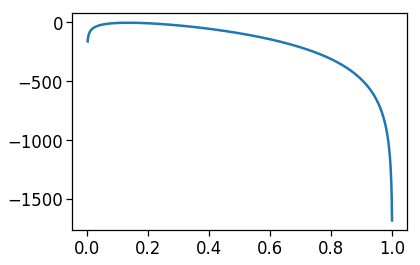

In [30]:
sns.lineplot(x=thetas,y=loglikelihood(thetas))

>**Figure 2.6.** Plot of the log likelihood function for $n=300$ and $y=40$.

The maximum lies at 40/300 = 0.1333… , consistent with intuition, but we see that other values of $\theta$ are almost equally likely, as the function is quite flat around the maximum. We will see in a later section how Bayesian methods allow us to use a range of values for $\theta$.

## 2.5. More boxes: multinomial data
---------------

### 2.5.1. DNA count modeling: base pairs

There are four basic molecules of DNA: A - adenine, C - cytosine, G - guanine, T - thymine. The nucleotides are classified into 2 groups: purines (A and G) and pyrimidines (C and T). The binomial would work as a model for the purine/pyrimidine groupings but not if we want to use A, C, G, T; for that we need the multinomial model from 1.4. Let’s look at noticeable patterns that occur in these frequencies.

### 2.5.2. Nucleotide bias

This section combines estimation and testing by simulation in a real example. Data from one strand of DNA for the genes of *Staphylococcus aureus* bacterium are available in a fasta file `staphsequence.ffn.txt`, which we can read with a function from the package [BioPython](https://biopython.org/):

In [31]:
pip install biopython

    100% |████████████████████████████████| 2.2MB 13.0MB/s 


In [32]:
!wget https://raw.githubusercontent.com/nekrut/msmb_python/master/data/staphsequence.ffn.txt

--2019-04-16 13:19:29--  https://raw.githubusercontent.com/nekrut/msmb_python/master/data/staphsequence.ffn.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2788929 (2.7M) [text/plain]
Saving to: ‘staphsequence.ffn.txt’

staphsequence.ffn.t 100%[===================>]   2.66M  --.-KB/s    in 0.1s    

2019-04-16 13:19:29 (25.8 MB/s) - ‘staphsequence.ffn.txt’ saved [2788929/2788929]



In [0]:
from Bio import SeqIO
with open('staphsequence.ffn.txt','r') as handle:
  genes = list(SeqIO.parse(handle,"fasta"))

Let's look at the first gene:

In [34]:
genes[0]

SeqRecord(seq=Seq('ATGTCGGAAAAAGAAATTTGGGAAAAAGTGCTTGAAATTGCTCAAGAAAAATTA...TAA', SingleLetterAlphabet()), id='lcl|NC_002952.2_cdsid_YP_039478.1', name='lcl|NC_002952.2_cdsid_YP_039478.1', description='lcl|NC_002952.2_cdsid_YP_039478.1 [gene=dnaA] [protein=chromosomal replication initiation protein] [protein_id=YP_039478.1] [location=517..1878]', dbxrefs=[])

In [35]:
[genes[0].seq.count(x) for x in 'ACGT']

[522, 219, 229, 392]

Due to their different physcal properties, evolutionary selection can act on the nucleotide frequencies. So we can ask whether, say, the first ten genes from these data come from the same multinomial. We do not have a prior reference, we just want to decide whether the nucleotides occur in the same proportions in the first 10 genes. If not, this would provide us with evidence for varying selective pressure on these ten genes.

In [0]:
import pandas as pd
tab10 = pd.DataFrame(index=('A','C','G','T'))

In [0]:
for i, gene in enumerate(genes[:10]):
  tab10['gene{}'.format(i)] = [gene.seq.count(x) for x in 'ACGT']

In [38]:
tab10

,gene0,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9
A,522,413,85,411,685,887,275,510,487,191
C,219,176,31,168,293,395,137,244,180,111
G,229,193,56,207,423,586,169,316,263,142
T,392,352,74,327,531,793,250,445,357,252


In [0]:
prop10 = (tab10/tab10.sum()).round(2)

In [40]:
prop10

,gene0,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9
A,0.38,0.36,0.35,0.37,0.35,0.33,0.33,0.34,0.38,0.27
C,0.16,0.16,0.13,0.15,0.15,0.15,0.16,0.16,0.14,0.16
G,0.17,0.17,0.23,0.19,0.22,0.22,0.20,0.21,0.20,0.20
T,0.29,0.31,0.30,0.29,0.27,0.30,0.30,0.29,0.28,0.36


In [0]:
p0 = np.array(prop10.mean(axis=1))

In [42]:
p0

array([0.346, 0.152, 0.201, 0.299])

So let’s suppose `p0` is the vector of multinomial probabilities for all the ten genes and use a Monte Carlo simulation to test whether the departures between the observed letter frequencies and expected values under this supposition are within a plausible range.

We compute the expected counts by taking the outer product of the vector of probabilities p0 with the sums of nucleotide counts from each of the 10 columns, `cs`:

In [0]:
cs = pd.DataFrame(tab10.sum()).T

In [44]:
cs

,gene0,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9
0,1362,1134,246,1113,1932,2661,831,1515,1287,696


In [0]:
expectedtab10 = pd.DataFrame(index=('A','C','G','T'))

In [0]:
for column in cs:
  for value in cs[column]:
    expectedtab10[column]=[ value*x for x in p0 ]

In [0]:
expectedtab10 = expectedtab10.round()

In [48]:
expectedtab10

,gene0,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9
A,471.0,392.0,85.0,385.0,668.0,921.0,288.0,524.0,445.0,241.0
C,207.0,172.0,37.0,169.0,294.0,404.0,126.0,230.0,196.0,106.0
G,274.0,228.0,49.0,224.0,388.0,535.0,167.0,305.0,259.0,140.0
T,407.0,339.0,74.0,333.0,578.0,796.0,248.0,453.0,385.0,208.0


In [0]:
randomtab10 = pd.DataFrame(index=('A','C','G','T'))

We can now create a random table with the correct column sums using the rmultinom function. This table is generated according to the null hypothesis that the true proportions are given by `p0`.

In [0]:
from scipy.stats import multinomial

In [0]:
for column in cs:
  for value in cs[column]:
    randomtab10[column]=multinomial.rvs(n=value,p=p0)

In [52]:
randomtab10

,gene0,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9
A,516,384,88,375,708,909,300,512,421,209
C,193,175,48,155,261,405,122,225,212,117
G,272,220,45,241,350,545,167,294,250,133
T,381,355,65,342,613,802,242,484,404,237


In [53]:
randomtab10.sum() == cs

,gene0,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9
0,True,True,True,True,True,True,True,True,True,True


Now we repeat this B = 1000 times. For each table we compute our test statistic from Section 1.4.1 in Lecture 1 (the function stat) and store the results in the vector `simulstat`. Together, these values constitute our null distribution, as they were generated under the null hypothesis that `p0` is the vector of multinomial proportions for each of the 10 genes.

In [0]:
simulstat = np.zeros(1000)

In [0]:
for i in range(1000):
  for column in cs:
    for value in cs[column]:
      randomtab10[column]=multinomial.rvs(n=value,p=p0)
  simulstat[i] = ((randomtab10-expectedtab10)**2/expectedtab10).values.sum()

In [0]:
S1 = ((tab10-expectedtab10)**2/expectedtab10).values.sum()

In [57]:
S1

70.79264053150476

In [58]:
np.sum(simulstat >= S1)

0

The histogram is shown in Figure 2.7. We see that the probability of seeing a value as large as $S1=70.8$ is very small under the null model. It happened 0 times in our 1000 simulations that a value as big as `S1` occured. Thus the ten genes do not seem to come from the same multinomial model.

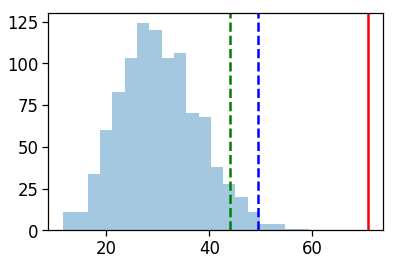

In [59]:
g = sns.distplot(simulstat, bins=20, kde=False)
g.axvline(S1,color='red')
g.axvline(np.quantile(simulstat,0.95),color='g',linestyle="--")
g.axvline(np.quantile(simulstat,0.99),color='b',linestyle="--")

>**Figure 2.7.**: Histogram of `simulstat`. The value of `S1` is marked by the vertical red line, those of the 0.95 and 0.99 quantiles (see next section) by the dotted lines.

## 2.6. The $\chi^2$ distribution
----------

In fact, we could have used statistical theory to come to the same conclusion without running these simulations. The theoretical distribution of the simulstat statistic is called the $\chi^2$ (chi-squared) distribution (Strictly speaking, the distribution of simulstat is approximately described by a $\chi^2$ distribution; the approximation is particularly good if the counts in the table are large.) with parameter 30 ($=10 \times (4-1)$). We can use this for computing the probability of having a value as large as S1 = 70.1. As we just saw above, small probabilities are difficult to compute by Monte Carlo: the granularity of the computation is $1/B$, so we cannot estimate any probabilities smaller than that, and in fact the uncertainty of the estimate is larger. So if any theory is applicable, that tends to be useful. We can check how well theory and simulation match up in our case using another visual goodness-of-fit tool: the (QQ) plot. When comparing two distributions, whether from two different samples or from one sample versus a theoretical model, just looking at histograms is not informative enough. We use a method based on the quantiles of each of the distributions.

### 2.6.1. Intermezzo: quantiles and the quantile-quantile plot

In the previous chapter, we ordered the 100 sample values $x_{(1)}, x_{(2)}, .... , x_{(100)}$. Say we want the 22nd percentile. We can take any value between the 22nd and the 23rd value, i.e., any value that fulfills $x_{(22)} \leq c_{0.22} \leq x_{(23)}$ is acceptable as a 0.22 quantile ($c_{0.22}$). In other words $c_{0.22}$ is defined by:

$ \frac{\#x'_{i}s \leq c_{0.22}}{n} = 0.22 $

Now that we have an idea what quantiles are, we can do the quantile-quantile plot. We plot the quantiles of the simulstat values, which we simulated under the null hypothesis, against the theoretical null distribution $\chi^2_{30}$
 (Figure 2.8):

In [0]:
from scipy.stats import probplot
from scipy.stats import chi2


In [0]:
x,y=probplot(simulstat,dist=chi2,sparams=(30,))[0]

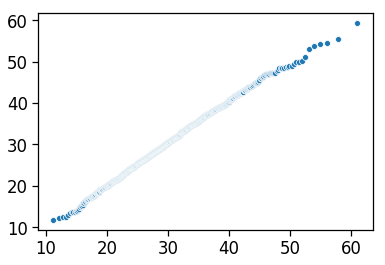

In [62]:
sns.scatterplot(x=x,y=y)

Having convinced ourselves that simulstat is well described by a $\chi^2_{30}$ distribution, we can use that to compute our $p$-value, i.e., the probability that under the null hypothesis (counts are distributed as multinomial with probabilities $p_A=0.35, p_C=0.15, p_G=0.2, p_T=0.3$ we observe a value as high as S1=70.1:

In [63]:
chi2.pdf(S1,df=30)

1.1790947465346944e-05

With such a small $p$-value, the null hypothesis seems improbable. Note how this computation did not require the 1000 simulations and was faster.

## 2.7. Chargaff's rule
---------

The most important pattern in the nucleotide frequencies was discovered by Chargaff ([Elson and Chargaff 1952](https://link.springer.com/article/10.1007/BF02170221)).

 
Long before DNA sequencing was available, using the weight of the molecules, he asked whether the nucleotides occurred at equal frequencies. He called this the tetranucleotide hypothesis. We would translate that into asking whether $p_A=p_C=p_G=p_T$.

Unfortunately, Chargaff only published the percentages of the mass present in different organisms for each of the nucleotides, not the measurements themselves.


In [64]:
!wget https://github.com/nekrut/msmb_python/raw/master/data/ChargaffTable.csv

--2019-04-16 13:20:02--  https://github.com/nekrut/msmb_python/raw/master/data/ChargaffTable.csv
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nekrut/msmb_python/master/data/ChargaffTable.csv [following]
--2019-04-16 13:20:02--  https://raw.githubusercontent.com/nekrut/msmb_python/master/data/ChargaffTable.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 260 [text/plain]
Saving to: ‘ChargaffTable.csv’

ChargaffTable.csv   100%[===================>]     260  --.-KB/s    in 0s      

2019-04-16 13:20:02 (28.5 MB/s) - ‘ChargaffTable.csv’ saved [260/260]



In [0]:
chargaff = pd.read_csv('ChargaffTable.csv')

In [66]:
chargaff.head()

,Species,A,T,C,G
0,Human-Thymus,30.9,29.4,19.9,19.8
1,Mycobac.Tuber,15.1,14.6,34.9,35.4
2,Chicken-Eryth.,28.8,29.2,20.5,21.5
3,Sheep-liver,29.3,29.3,20.5,20.7
4,Sea Urchin,32.8,32.1,17.7,17.3


In [0]:
chargaff = pd.melt(chargaff,id_vars=['Species'],var_name='base',value_name='frequency')

In [68]:
chargaff.head()

,Species,base,frequency
0,Human-Thymus,A,30.9
1,Mycobac.Tuber,A,15.1
2,Chicken-Eryth.,A,28.8
3,Sheep-liver,A,29.3
4,Sea Urchin,A,32.8


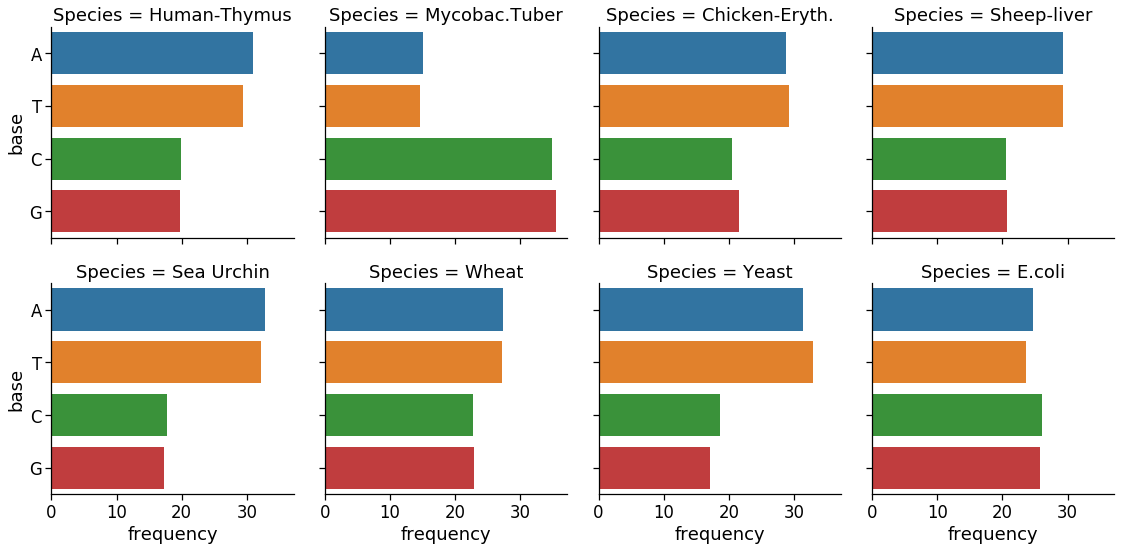

In [69]:
sns.catplot(kind='bar',x='frequency',y='base',col="Species",col_wrap=4,height=4,data=chargaff)

- Do these data seem to come from equally likely multinomial categories?
- Can you suggest an alternative pattern?
- Can you do a quantitative analysis of the pattern, perhaps inspired by the simulations above?

Chargaff saw the answer to this question and postulated a pattern called base pairing, which ensured a perfect match of the amount of adenine (A) in the DNA of an organism to the amount of thymine (T). Similarly, whatever the amount of guanine (G), the amount of cytosine (C) would be the same. This is now called Chargaff’s rule. On the other hand, the amount of C/G in an organism could be quite different from that of A/T, with no obvious pattern across organisms. Based on Chargaff’s rule, we might define a statistic:

$(p_C-p_G)^2+(p_A-p_T)^2,$

summed over all rows of the table. We are going to look at a comparison between the data and what would occur if the nucleotides were ‘exchangeable’, in the sense that the probabilities observed in each row were in no particular order, so that there were no special relationship between the proportions of As and Ts, or between those of Cs and Gs.

#### Color blindness and sex

Deuteranopia is a form of red-green color blindness due to the fact that medium wavelength sensitive cones (green) are missing. A deuteranope can only distinguish 2 to 3 different hues, whereas somebody with normal vision sees 7 different hues. A survey for this type of color blindness in human subjects produced a two-way table crossing color blindness and sex.

In [0]:
Deuteranopia = pd.DataFrame(index=['Deute','NonDeute'],data={'Men':[19,1981],'Women':[2,1998]})

In [75]:
Deuteranopia

,Men,Women
Deute,19,2
NonDeute,1981,1998


How do we test whether there is a relationship between sex and the occurrence of color blindness? We postulate the null model with two independent binomials: one for sex and one for color blindness. Under this model we can estimate all the cells’ multinomial probabilities, and we can compare the observed counts to the expected ones. This is done through the `chi2_contingency` function in `scipy.stats` package:

In [0]:
from scipy.stats import chi2_contingency

In [0]:
chi2, p, dof, ex = chi2_contingency(Deuteranopia,correction=True)

In [82]:
print('X-squared = {}, df = {}, p-value = {}'.format(chi2,dof,p))

X-squared = 12.254813963786066, df = 1, p-value = 0.000464059415494955


The small $p$ value tells us that we should expect to see such a table with only a very small probability under the null model – i.e., if the fractions of deuteranopic color blind among women and men were the same.

We’ll see another test for this type of data called Fisher’s exact test (also known as the hypergeometric test) in section 10.3.2. This test is widely used for testing the over-representations of certain types of genes in a list of significantly expressed ones.